In [69]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import importlib, utils

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table

## Set up Spark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 07:53:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Set up Config

In [30]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

## Build Bronze Table

In [62]:
BRONZE_DATASETS = [
    {
        "name": "feature_clickstream",
        "csv_file_path": "data/feature_clickstream.csv",
        "bronze_partition": "bronze_features_clickstream_",
        "bronze_path": "datamart/bronze/features_clickstream/",
        "update_type": "append"
    },
    {
        "name": "features_attributes",
        "csv_file_path": "data/features_attributes.csv",
        "bronze_partition": "bronze_features_attribute_",
        "bronze_path": "datamart/bronze/features_attributes/",
        "update_type": "overwrite"
    },
    {
        # Overwrite-at-source; we stamp each ingest with "today"
        "name": "features_financials",
        "csv_file_path": "data/features_financials.csv",
        "bronze_partition": "bronze_features_financials_",
        "bronze_path": "datamart/bronze/features_financials/",
        "update_type": "overwrite"
    },
    {
        "name": "lms_loan_daily",
        "csv_file_path": "data/lms_loan_daily.csv",
        "bronze_partition": "bronze_lms_loan_daily_",
        "bronze_path": "datamart/bronze/lms_loan_daily/",
        "update_type": "append"
    },
]

In [63]:
dates_str_lst = {}

for file in BRONZE_DATASETS:

    table_name = file["name"]
    csv_file_path = file["csv_file_path"]
    update_type = file["update_type"]

    if update_type=="append":
        df = pd.read_csv(file["csv_file_path"])
        min_date = df["snapshot_date"].min()
        max_date = df["snapshot_date"].max()
        dates = generate_first_of_month_dates(min_date, max_date)

    else:
        min_date = pd.to_datetime(date.today()).strftime("%Y-%m-%d")
        max_date = min_date
        dates = generate_first_of_month_dates(min_date, max_date)

    dates_str_lst[table_name] = dates

In [64]:
dates_str_lst

{'feature_clickstream': ['2023-01-01',
  '2023-02-01',
  '2023-03-01',
  '2023-04-01',
  '2023-05-01',
  '2023-06-01',
  '2023-07-01',
  '2023-08-01',
  '2023-09-01',
  '2023-10-01',
  '2023-11-01',
  '2023-12-01',
  '2024-01-01',
  '2024-02-01',
  '2024-03-01',
  '2024-04-01',
  '2024-05-01',
  '2024-06-01',
  '2024-07-01',
  '2024-08-01',
  '2024-09-01',
  '2024-10-01',
  '2024-11-01',
  '2024-12-01'],
 'features_attributes': ['2025-10-01'],
 'features_financials': ['2025-10-01'],
 'lms_loan_daily': ['2023-01-01',
  '2023-02-01',
  '2023-03-01',
  '2023-04-01',
  '2023-05-01',
  '2023-06-01',
  '2023-07-01',
  '2023-08-01',
  '2023-09-01',
  '2023-10-01',
  '2023-11-01',
  '2023-12-01',
  '2024-01-01',
  '2024-02-01',
  '2024-03-01',
  '2024-04-01',
  '2024-05-01',
  '2024-06-01',
  '2024-07-01',
  '2024-08-01',
  '2024-09-01',
  '2024-10-01',
  '2024-11-01',
  '2024-12-01',
  '2025-01-01',
  '2025-02-01',
  '2025-03-01',
  '2025-04-01',
  '2025-05-01',
  '2025-06-01',
  '2025-07-01'

In [66]:
for file in BRONZE_DATASETS:

    table_name = file["name"]
    csv_file_path = file["csv_file_path"]
    bronze_directory = file["bronze_path"]
    bronze_partition = file["bronze_partition"]
    update_type = file["update_type"]
    df = pd.read_csv(csv_file_path)

    if not os.path.exists(bronze_directory):
        os.makedirs(bronze_directory)
    
    if update_type=="append":
        # run bronze backfill
        for date_str in dates_str_lst[table_name]:
            utils.data_processing_bronze_table.process_bronze_table_append(date_str, csv_file_path, bronze_partition, bronze_directory, spark)

    else:
        # run bronze backfill
        for date_str in dates_str_lst[table_name]:
            utils.data_processing_bronze_table.process_bronze_table_overwrite(date_str, csv_file_path, bronze_partition, bronze_directory, spark)

2023-01-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_05_01.csv
2023-06-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_08_01.csv


2023-09-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_09_01.csv


2023-10-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_10_01.csv
2023-11-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_11_01.csv


2023-12-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_12_01.csv


2024-01-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_01_01.csv


2024-02-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_02_01.csv
2024-03-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_03_01.csv


2024-04-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_04_01.csv
2024-05-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_05_01.csv


2024-06-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_06_01.csv
2024-07-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_07_01.csv


2024-08-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_08_01.csv


2024-09-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_09_01.csv
2024-10-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_10_01.csv
2024-11-01row count: 8974
saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_11_01.csv
2024-12-01row count: 8974


saved to: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_12_01.csv
2025-10-01row count: 12500
saved to: datamart/bronze/features_attributes/bronze_features_attribute_2025_10_01.csv
2025-10-01row count: 12500


saved to: datamart/bronze/features_financials/bronze_features_financials_2025_10_01.csv
2023-01-01row count: 530


saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_03_01.csv
2023-04-01row count: 2047


saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_04_01.csv


2023-05-01row count: 2568
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_05_01.csv
2023-06-01row count: 3085
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_06_01.csv
2023-07-01row count: 3556
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_07_01.csv
2023-08-01row count: 4037
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_08_01.csv
2023-09-01row count: 4491
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_09_01.csv
2023-10-01row count: 4978
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_10_01.csv
2023-11-01row count: 5469
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_11_01.csv
2023-12-01row count: 5428
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_12_01.csv
2024-01-01row count: 5412
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_01_01.csv
2024-02-01row count: 5424
saved to: datamart/bronze/lms_loan_dai

2025-01-01row count: 5539
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_01_01.csv
2025-02-01row count: 5028


saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_02_01.csv
2025-03-01row count: 4515
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_03_01.csv
2025-04-01row count: 4024
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_04_01.csv
2025-05-01row count: 3526
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_05_01.csv
2025-06-01row count: 3021
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_06_01.csv
2025-07-01row count: 2478
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_07_01.csv
2025-08-01row count: 1985
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_08_01.csv
2025-09-01row count: 1529
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_09_01.csv
2025-10-01row count: 1041


saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_10_01.csv
2025-11-01row count: 526
saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_11_01.csv


## Build Silver Table

In [67]:
SILVER_DATASETS = [
    {
        "name": "feature_clickstream",
        "bronze_path": "datamart/bronze/features_clickstream/",
        "silver_path": "datamart/silver/features_clickstream/"
    },
    {
        "name": "features_attributes",
        "bronze_path": "datamart/bronze/features_attributes/",
        "silver_path": "datamart/silver/features_attributes/"
    },
    {
        "name": "features_financials",
        "bronze_path": "datamart/bronze/features_financials/",
        "silver_path": "datamart/silver/features_financials/"
    },
    {
        "name": "lms_loan_daily",
        "bronze_path": "datamart/bronze/lms_loan_daily/",
        "silver_path": "datamart/silver/lms_loan_daily/"
    },
]

In [68]:
# update silver processing file:
importlib.reload(utils.data_processing_silver_table)
silver_processing = importlib.import_module("utils.data_processing_silver_table")

for file in SILVER_DATASETS:

    table_name = file["name"]
    bronze_directory = file["bronze_path"]
    silver_directory = file["silver_path"]
    func = silver_processing.REGISTRY.get(table_name)

    if not os.path.exists(silver_directory):
        os.makedirs(silver_directory)

    # run silver backfill
    for date_str in dates_str_lst[table_name]:
        func(date_str, bronze_directory, silver_directory, spark)

loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_01_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_01_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_02_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_02_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_03_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_03_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_04_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_04_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_05_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_05_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_06_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_06_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_07_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_07_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_08_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_08_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_09_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_09_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_10_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_10_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_11_01.csv row count: 8974


saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_11_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2023_12_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2023_12_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_01_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2024_01_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_02_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2024_02_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_03_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2024_03_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_04_01.csv r

saved to: datamart/silver/features_clickstream/silver_features_clickstream_2024_11_01.parquet
loaded from: datamart/bronze/features_clickstream/bronze_features_clickstream_2024_12_01.csv row count: 8974
saved to: datamart/silver/features_clickstream/silver_features_clickstream_2024_12_01.parquet
loaded from: datamart/bronze/features_attributes/bronze_features_attribute_2025_10_01.csv row count: 12500
saved to: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet
loaded from: datamart/bronze/features_financials/bronze_features_financials_2025_10_01.csv row count: 12500


saved to: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_01_01.csv row count: 530
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_04_01.csv row count: 2047
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_04_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_05_01.csv row count: 2568
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_05_01.parquet
loaded from: d

saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_12_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_01_01.csv row count: 5412
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_01_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_02_01.csv row count: 5424
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_02_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_03_01.csv row count: 5425


saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_03_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_04_01.csv row count: 5417
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_04_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_05_01.csv row count: 5391
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_05_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_06_01.csv row count: 5418
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_06_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_07_01.csv row count: 5442
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_07_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_08_01.csv row count: 5531
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_08_01.parquet
loaded from: datamart/b

saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_11_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2024_12_01.csv row count: 5531
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_12_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_01_01.csv row count: 5539
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_01_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_02_01.csv row count: 5028
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_02_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_03_01.csv row count: 4515
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_03_01.parquet
loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2025_04_01.csv row count: 4024
saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_04_01.parquet
loaded from: datamart/b

## EDA on credit labels

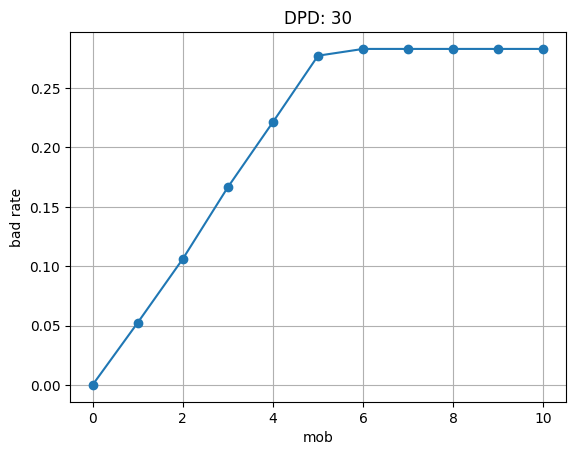

In [61]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = "datamart/silver/lms_loan_daily/"

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()

## Build Gold Table - Label Store

In [71]:
# create gold table datalake
silver_directory = "datamart/silver/lms_loan_daily/"
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [72]:
for date_str in dates_str_lst["lms_loan_daily"]:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)

loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_01_01.parquet row count: 530


saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_02_01.parquet row count: 1031


saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_07_01.parquet row count: 3556


saved to: datamart/gold/label_store/gold_label_store_2023_07_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_08_01.parquet row count: 4037
saved to: datamart/gold/label_store/gold_label_store_2023_08_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_09_01.parquet row count: 4491
saved to: datamart/gold/label_store/gold_label_store_2023_09_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_10_01.parquet row count: 4978


saved to: datamart/gold/label_store/gold_label_store_2023_10_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_11_01.parquet row count: 5469


saved to: datamart/gold/label_store/gold_label_store_2023_11_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_12_01.parquet row count: 5428


saved to: datamart/gold/label_store/gold_label_store_2023_12_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_01_01.parquet row count: 5412


saved to: datamart/gold/label_store/gold_label_store_2024_01_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_02_01.parquet row count: 5424


saved to: datamart/gold/label_store/gold_label_store_2024_02_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_03_01.parquet row count: 5425


saved to: datamart/gold/label_store/gold_label_store_2024_03_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_04_01.parquet row count: 5417


saved to: datamart/gold/label_store/gold_label_store_2024_04_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_05_01.parquet row count: 5391
saved to: datamart/gold/label_store/gold_label_store_2024_05_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_06_01.parquet row count: 5418
saved to: datamart/gold/label_store/gold_label_store_2024_06_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_07_01.parquet row count: 5442
saved to: datamart/gold/label_store/gold_label_store_2024_07_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_08_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_08_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_09_01.parquet row count: 5537
saved to: datamart/gold/label_store/gold_label_store_2024_09_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_dai

saved to: datamart/gold/label_store/gold_label_store_2024_11_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_01_01.parquet row count: 5539
saved to: datamart/gold/label_store/gold_label_store_2025_01_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_02_01.parquet row count: 5028
saved to: datamart/gold/label_store/gold_label_store_2025_02_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_03_01.parquet row count: 4515


saved to: datamart/gold/label_store/gold_label_store_2025_03_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_04_01.parquet row count: 4024
saved to: datamart/gold/label_store/gold_label_store_2025_04_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_05_01.parquet row count: 3526
saved to: datamart/gold/label_store/gold_label_store_2025_05_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_06_01.parquet row count: 3021
saved to: datamart/gold/label_store/gold_label_store_2025_06_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_07_01.parquet row count: 2478
saved to: datamart/gold/label_store/gold_label_store_2025_07_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_08_01.parquet row count: 1985
saved to: datamart/gold/label_store/gold_label_store_2025_08_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_dai

saved to: datamart/gold/label_store/gold_label_store_2025_11_01.parquet


In [73]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes

loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2025_11_01.parquet row count: 526
saved to: datamart/gold/label_store/gold_label_store_2025_11_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

In [74]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 12500
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    1|30dpd_6mob|   2025-02-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    1|30dpd_6mob|   2025-02-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1378_2024_0...| CUS_0x1378|    1|30dpd_6mob|   2025-02-01|
|CUS_0x139b_2024_0...| CUS_0x139b|    0|30dpd_6mob|   2025-

## Build Gold Table - Feature Store

In [88]:
# create gold table datalake
gold_label_store_directory = "datamart/gold/label_store/"
gold_feature_store_directory = "datamart/gold/feature_store/"
silver_attribute_directory = "datamart/silver/features_attributes/"
silver_financials_directory = "datamart/silver/features_financials/"
feature_date_str = dates_str_lst["features_attributes"][0]

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [99]:
importlib.reload(utils.data_processing_gold_table)

<module 'utils.data_processing_gold_table' from '/app/utils/data_processing_gold_table.py'>

In [100]:
for date_str in dates_str_lst["lms_loan_daily"]:
    utils.data_processing_gold_table.process_features_gold_table(date_str, gold_label_store_directory, gold_feature_store_directory, feature_date_str, silver_attribute_directory, silver_financials_directory, spark)

loaded from: datamart/gold/label_store/gold_label_store_2023_01_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2023_02_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2023_02_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2023_03_01.parquet row count: 0
loaded feature attribu

saved to: datamart/gold/feature_store/gold_feature_store_2024_01_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_02_01.parquet row count: 481
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_02_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_03_01.parquet row count: 454
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_03_01.parquet
next snapshot date
loaded from

saved to: datamart/gold/feature_store/gold_feature_store_2024_05_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_06_01.parquet row count: 489
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_06_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_07_01.parquet row count: 485
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_07_01.parquet
next snapshot date
loaded from

saved to: datamart/gold/feature_store/gold_feature_store_2024_08_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_09_01.parquet row count: 511
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500


saved to: datamart/gold/feature_store/gold_feature_store_2024_09_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_10_01.parquet row count: 513
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_10_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2024_11_01.parquet row count: 491
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2024_11_01.parquet
next snapshot date
loaded from

saved to: datamart/gold/feature_store/gold_feature_store_2024_12_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_01_01.parquet row count: 505
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2025_01_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_02_01.parquet row count: 543
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2025_02_01.parquet
next snapshot date
loaded from

saved to: datamart/gold/feature_store/gold_feature_store_2025_06_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_07_01.parquet row count: 526
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500


saved to: datamart/gold/feature_store/gold_feature_store_2025_07_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_08_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500


saved to: datamart/gold/feature_store/gold_feature_store_2025_08_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_09_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500


saved to: datamart/gold/feature_store/gold_feature_store_2025_09_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_10_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2025_10_01.parquet
next snapshot date
loaded from: datamart/gold/label_store/gold_label_store_2025_11_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2025_11_01.parquet
next snapshot date


In [101]:
utils.data_processing_gold_table.process_features_gold_table(date_str, gold_label_store_directory, gold_feature_store_directory, feature_date_str, silver_attribute_directory, silver_financials_directory, spark).dtypes

loaded from: datamart/gold/label_store/gold_label_store_2025_11_01.parquet row count: 0
loaded feature attributes from: datamart/silver/features_attributes/silver_features_attributes_2025_10_01.parquet row count: 12500
loaded feature financials from: datamart/silver/features_financials/silver_features_financials_2025_10_01.parquet row count: 12500
saved to: datamart/gold/feature_store/gold_feature_store_2025_11_01.parquet
next snapshot date


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('Age_as_of', 'int'),
 ('Occupation', 'string'),
 ('Annual_Income', 'float'),
 ('Credit_Mix', 'string'),
 ('snapshot_date', 'date')]

In [102]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 12500
+--------------------+-----------+---------+------------+-------------+----------+-------------+
|             loan_id|Customer_ID|Age_as_of|  Occupation|Annual_Income|Credit_Mix|snapshot_date|
+--------------------+-----------+---------+------------+-------------+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|       29|   Developer|    16718.645|   Unknown|   2025-02-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|       24|     Unknown|    158623.16|      Good|   2025-02-01|
|CUS_0x1145_2024_0...| CUS_0x1145|       24|     Teacher|     17975.32|       Bad|   2025-02-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|       26|  Journalist|     69136.54|  Standard|   2025-02-01|
|CUS_0x122c_2024_0...| CUS_0x122c|       48|Entrepreneur|     36346.13|      Good|   2025-02-01|
|CUS_0x1274_2024_0...| CUS_0x1274|      100|   Scientist|     49070.94|  Standard|   2025-02-01|
|CUS_0x1288_2024_0...| CUS_0x1288|       34|      Doctor|     60938.13|       Bad|   2025-02-01|
|CUS_0x12cc_2

In [4]:
!jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True data_processing_main.ipynb

[NbConvertApp] Converting notebook data_processing_main.ipynb to python
[NbConvertApp] Writing 9032 bytes to data_processing_main.py
